# 平板玻璃行业碳排放量预测模型

本 notebook 使用 XGBoost 模型预测平板玻璃企业的碳排放量。

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import re
import ipywidgets as widgets
from IPython.display import display
import sys
import os

# 确保可以导入 utils.py
sys.path.append(os.path.dirname(os.getcwd()))
from utils import GlassIndustryEmissions

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

## 1. 数据加载和预处理

In [2]:
# 读取数据
df = pd.read_csv("./datasets/平板玻璃.csv", encoding="utf-8")
print(f"原始数据形状: {df.shape}")
df.head()

原始数据形状: (48, 16)


,企业,年份,化石燃料净消耗量,平均低位发热量,单位热值含碳量,碳氧化率,碳粉消耗量,加权平均含碳量,碳酸盐原料消耗量,碳酸盐特定排放因子,碳酸盐煅烧率,净购入电量,区域电网排放因子,净购入热力,热力排放因子,碳排放量
0,信义玻璃,2021,"85,000",43.5 (重油),20.8,92.0,800,21.2,28.5,0.41,88,12.5,0.65 (南方),8.2,0.10 (重油锅炉),"1,823,416"
1,福耀玻璃,2022,"78,000",46.2 (天然气),15.3,95.0,500,15.8,25.8,0.41,91,10.8,0.78 (华东),6.5,0.07 (天然气锅炉),"1,987,235"
2,金晶科技,2023,"92,000",27.8 (煤气),24.5,89.0,"1,200",25.0,32.1,0.40,85,15.3,0.72 (华北),9.8,0.12 (煤气余热),"2,431,609"
3,南玻集团,2024,"68,000",48.0 (天然气),15.2,97.0,300,15.5,20.4,0.41,94,8.7,0.65 (南方),4.2,0.06 (热电联产),"1,654,892"
4,旗滨集团,2025,"55,000",49.5 (掺氢),14.8,98.0,200,15.0,18.6,0.41,96,7.2,0.65 (南方),3.5,0.05 (氢能辅助),"1,298,417"


In [3]:
# 数据清洗：去除括号及括号中的中文内容
def clean_brackets(text):
    if isinstance(text, str):
        # 去除括号及括号中的内容
        return re.sub(r"\(.*?\)", "", text).strip()
    return text


# 处理数值列中的千位分隔符和括号
def process_numeric(text):
    if isinstance(text, str):
        # 去除括号及括号内内容
        text = re.sub(r"\s*\(.*?\)\s*", "", text)
        # 去除逗号
        text = text.replace(",", "")
        # 转为浮点数
        return float(text)
    return text


# 创建数据副本以进行处理
processed_df = df.copy()

# 应用数据清洗函数
for col in processed_df.columns:
    if col == "企业" or col == "年份":
        processed_df[col] = processed_df[col].apply(clean_brackets)
    else:
        processed_df[col] = processed_df[col].apply(process_numeric)

# 显示处理后的数据
processed_df.head()

,企业,年份,化石燃料净消耗量,平均低位发热量,单位热值含碳量,碳氧化率,碳粉消耗量,加权平均含碳量,碳酸盐原料消耗量,碳酸盐特定排放因子,碳酸盐煅烧率,净购入电量,区域电网排放因子,净购入热力,热力排放因子,碳排放量
0,信义玻璃,2021,85000.0,43.5,20.8,92.0,800.0,21.2,28.5,0.41,88,12.5,0.65,8.2,0.10,1823416.0
1,福耀玻璃,2022,78000.0,46.2,15.3,95.0,500.0,15.8,25.8,0.41,91,10.8,0.78,6.5,0.07,1987235.0
2,金晶科技,2023,92000.0,27.8,24.5,89.0,1200.0,25.0,32.1,0.40,85,15.3,0.72,9.8,0.12,2431609.0
3,南玻集团,2024,68000.0,48.0,15.2,97.0,300.0,15.5,20.4,0.41,94,8.7,0.65,4.2,0.06,1654892.0
4,旗滨集团,2025,55000.0,49.5,14.8,98.0,200.0,15.0,18.6,0.41,96,7.2,0.65,3.5,0.05,1298417.0


## 2. 使用 utils.py 中的函数计算排放量特征

In [4]:
# 使用 GlassIndustryEmissions 类计算各排放源的排放量
def calculate_emissions(row):
    try:
        # 1. 化石燃料燃烧排放
        fossil_fuel_emission = GlassIndustryEmissions.calculate_fossil_fuel_emission(
            row["化石燃料净消耗量"],
            row["平均低位发热量"],
            row["单位热值含碳量"],
            row["碳氧化率"] / 100,  # 转为比例
        )

        # 2. 原料配料中碳粉氧化的排放
        carbon_powder_emission = (
            GlassIndustryEmissions.calculate_carbon_powder_emission(
                row["碳粉消耗量"], row["加权平均含碳量"]
            )
        )

        # 3. 原料分解产生的排放
        raw_material_emission = (
            GlassIndustryEmissions.calculate_raw_material_decomposition_emission(
                row["碳酸盐原料消耗量"],
                row["碳酸盐特定排放因子"],
                row["碳酸盐煅烧率"] / 100,  # 转为比例
            )
        )

        # 4. 净购入使用的电力和热力对应的排放
        power_heat_emission = (
            GlassIndustryEmissions.calculate_purchased_power_and_heat_emission(
                row["净购入电量"],
                row["区域电网排放因子"],
                row["净购入热力"],
                row["热力排放因子"],
            )
        )

        # 计算总排放量
        total_calculated_emission = (
            fossil_fuel_emission
            + carbon_powder_emission
            + raw_material_emission
            + power_heat_emission
        )

        return total_calculated_emission
    except Exception as e:
        print(f"计算排放量时出错: {e}")
        return np.nan


# 应用函数计算每行的总排放量
processed_df["计算的总排放量"] = processed_df.apply(calculate_emissions, axis=1)

# 显示原始碳排放量和计算的总排放量的对比
comparison_df = processed_df[["企业", "年份", "碳排放量", "计算的总排放量"]]
comparison_df["差异(%)"] = (
    (comparison_df["计算的总排放量"] - comparison_df["碳排放量"])
    / comparison_df["碳排放量"]
) * 100
comparison_df.head(10)

C:\Users\kyoci\AppData\Local\Temp\ipykernel_10200\2614586374.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df["差异(%)"] = (


,企业,年份,碳排放量,计算的总排放量,差异(%)
0,信义玻璃,2021,1823416.0,7.077234e+07,3781.305156
1,福耀玻璃,2022,1987235.0,5.238624e+07,2536.137372
2,金晶科技,2023,2431609.0,5.579849e+07,2194.714780
3,南玻集团,2024,1654892.0,4.812908e+07,2808.291282
4,旗滨集团,2025,1298417.0,3.949015e+07,2941.407512
5,中国玻璃控股,2021,2831456.0,4.717604e+07,1566.140560
6,洛玻集团,2022,2467890.0,6.656750e+07,2597.344812
7,台玻集团,2023,1795320.0,4.422439e+07,2363.315414
8,耀皮玻璃,2024,2163750.0,5.723450e+07,2545.153017
9,中航三鑫,2025,1305680.0,3.396983e+07,2501.696426


In [5]:
# 检查数据中的缺失值
processed_df.isnull().sum()

企业           0
年份           0
化石燃料净消耗量     0
平均低位发热量      2
单位热值含碳量      2
碳氧化率         2
碳粉消耗量        0
加权平均含碳量      0
碳酸盐原料消耗量     0
碳酸盐特定排放因子    0
碳酸盐煅烧率       0
净购入电量        0
区域电网排放因子     0
净购入热力        0
热力排放因子       0
碳排放量         0
计算的总排放量      2
dtype: int64

## 3. 特征选择和数据准备

In [6]:
# 选择数值型特征作为输入
feature_columns = [
    "化石燃料净消耗量",
    "平均低位发热量",
    "单位热值含碳量",
    "碳氧化率",
    "碳粉消耗量",
    "加权平均含碳量",
    "碳酸盐原料消耗量",
    "碳酸盐特定排放因子",
    "碳酸盐煅烧率",
    "净购入电量",
    "区域电网排放因子",
    "净购入热力",
    "热力排放因子",
    "计算的总排放量",
]

# 处理凯盛科技-成都UTG玻璃和安彩高科-郑州光伏玻璃的NaN值
processed_df = processed_df.dropna(subset=feature_columns)

# 分割特征和目标变量
X = processed_df[feature_columns]
y = processed_df["碳排放量"]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"训练集大小: {X_train.shape}")
print(f"测试集大小: {X_test.shape}")

训练集大小: (36, 14)
测试集大小: (10, 14)


## 4. 模型训练与评估

In [7]:
# 创建XGBoost回归模型
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
)

# 训练模型
model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = model.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"均方误差(MSE): {mse:.2f}")
print(f"均方根误差(RMSE): {rmse:.2f}")
print(f"决定系数(R²): {r2:.4f}")

均方误差(MSE): 23769061368.03
均方根误差(RMSE): 154172.18
决定系数(R²): 0.9556


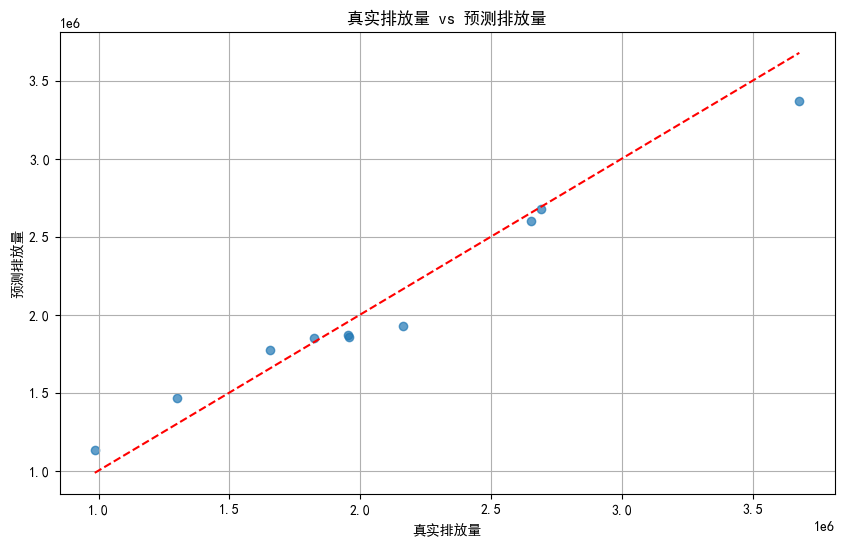

In [8]:
# 绘制真实值vs预测值散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("真实排放量")
plt.ylabel("预测排放量")
plt.title("真实排放量 vs 预测排放量")
plt.grid(True)
plt.show()

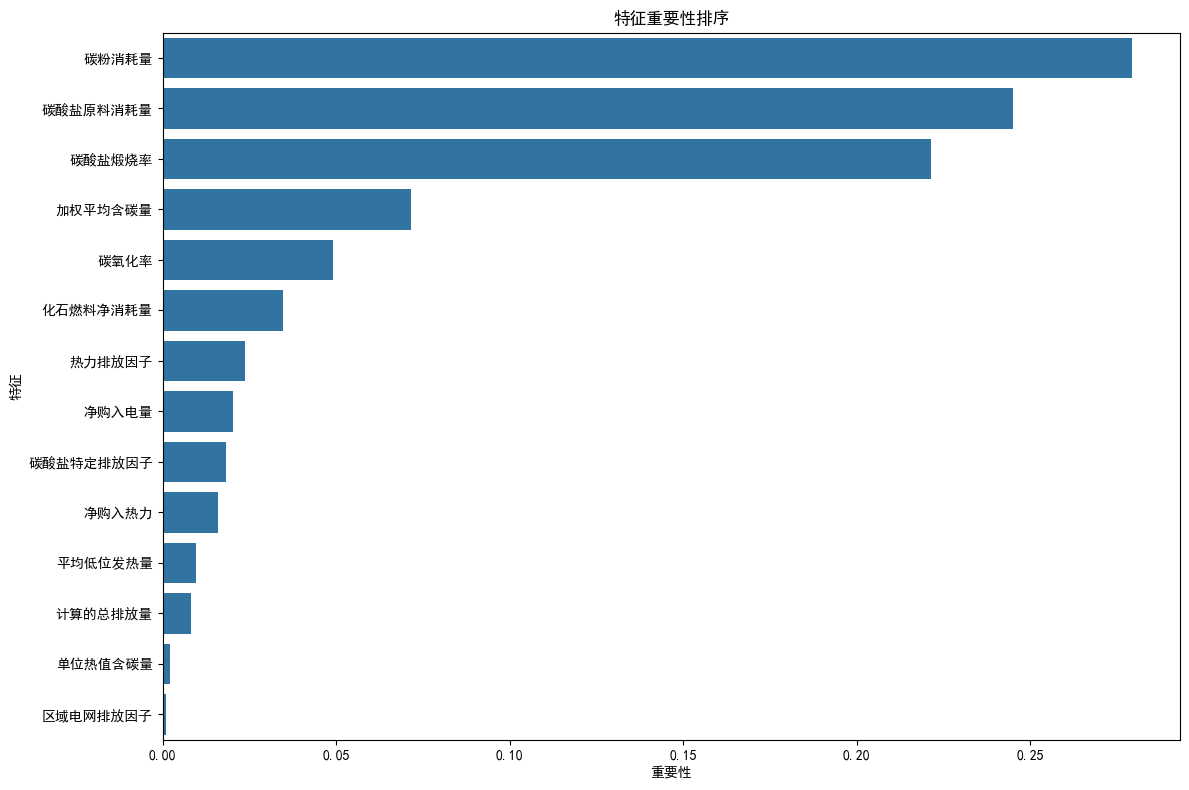

,特征,重要性
0,碳粉消耗量,0.279232
1,碳酸盐原料消耗量,0.244947
2,碳酸盐煅烧率,0.221461
3,加权平均含碳量,0.071477
4,碳氧化率,0.049176
5,化石燃料净消耗量,0.034775
6,热力排放因子,0.023630
7,净购入电量,0.020236
8,碳酸盐特定排放因子,0.018192
9,净购入热力,0.016014


In [9]:
# 分析特征重要性
feature_importance = model.feature_importances_
feature_names = X.columns

# 创建特征重要性DataFrame
importance_df = pd.DataFrame({"特征": feature_names, "重要性": feature_importance})

# 按重要性降序排列
importance_df = importance_df.sort_values("重要性", ascending=False).reset_index(
    drop=True
)

# 显示特征重要性
plt.figure(figsize=(12, 8))
sns.barplot(x="重要性", y="特征", data=importance_df)
plt.title("特征重要性排序")
plt.tight_layout()
plt.show()

importance_df

## 5. 使用ipywidgets创建交互式预测界面

In [ ]:
# 创建输入控件
fossil_fuel = widgets.FloatText(
    value=80000.0, description="化石燃料净消耗量:", disabled=False
)
heating_value = widgets.FloatText(
    value=40.0, description="平均低位发热量:", disabled=False
)
carbon_content = widgets.FloatText(
    value=20.0, description="单位热值含碳量:", disabled=False
)
oxidation_rate = widgets.FloatSlider(
    value=90, min=80, max=100, step=1, description="碳氧化率(%):", disabled=False
)
carbon_powder = widgets.FloatText(
    value=1000.0, description="碳粉消耗量:", disabled=False
)
avg_carbon_content = widgets.FloatText(
    value=20.0, description="加权平均含碳量:", disabled=False
)
carbonate_raw = widgets.FloatText(
    value=25.0, description="碳酸盐原料消耗量:", disabled=False
)
carbonate_factor = widgets.FloatText(
    value=0.41, description="碳酸盐特定排放因子:", disabled=False
)
calcination_rate = widgets.FloatSlider(
    value=90, min=80, max=100, step=1, description="碳酸盐煅烧率(%):", disabled=False
)
purchased_electricity = widgets.FloatText(
    value=15.0, description="净购入电量:", disabled=False
)
grid_factor = widgets.FloatText(
    value=0.7, description="区域电网排放因子:", disabled=False
)
purchased_heat = widgets.FloatText(
    value=10.0, description="净购入热力:", disabled=False
)
heat_factor = widgets.FloatText(value=0.1, description="热力排放因子:", disabled=False)

# 布局
inputs_box = widgets.VBox(
    [
        widgets.HBox([fossil_fuel, heating_value]),
        widgets.HBox([carbon_content, oxidation_rate]),
        widgets.HBox([carbon_powder, avg_carbon_content]),
        widgets.HBox([carbonate_raw, carbonate_factor]),
        widgets.HBox([calcination_rate, purchased_electricity]),
        widgets.HBox([grid_factor, purchased_heat]),
        widgets.HBox([heat_factor]),
    ]
)

# 输出控件
output = widgets.Output()

# 预测按钮
predict_button = widgets.Button(description="预测碳排放量")


# 预测函数
def calculate_and_predict(b):
    with output:
        output.clear_output()

        try:
            # 计算总排放量作为特征
            fossil_fuel_emission = (
                GlassIndustryEmissions.calculate_fossil_fuel_emission(
                    fossil_fuel.value,
                    heating_value.value,
                    carbon_content.value,
                    oxidation_rate.value / 100,
                )
            )

            carbon_powder_emission = (
                GlassIndustryEmissions.calculate_carbon_powder_emission(
                    carbon_powder.value, avg_carbon_content.value
                )
            )

            raw_material_emission = (
                GlassIndustryEmissions.calculate_raw_material_decomposition_emission(
                    carbonate_raw.value,
                    carbonate_factor.value,
                    calcination_rate.value / 100,
                )
            )

            power_heat_emission = (
                GlassIndustryEmissions.calculate_purchased_power_and_heat_emission(
                    purchased_electricity.value,
                    grid_factor.value,
                    purchased_heat.value,
                    heat_factor.value,
                )
            )

            total_calculated_emission = (
                fossil_fuel_emission
                + carbon_powder_emission
                + raw_material_emission
                + power_heat_emission
            )

            # 创建输入数据
            input_data = pd.DataFrame(
                {
                    "化石燃料净消耗量": [fossil_fuel.value],
                    "平均低位发热量": [heating_value.value],
                    "单位热值含碳量": [carbon_content.value],
                    "碳氧化率": [oxidation_rate.value],
                    "碳粉消耗量": [carbon_powder.value],
                    "加权平均含碳量": [avg_carbon_content.value],
                    "碳酸盐原料消耗量": [carbonate_raw.value],
                    "碳酸盐特定排放因子": [carbonate_factor.value],
                    "碳酸盐煅烧率": [calcination_rate.value],
                    "净购入电量": [purchased_electricity.value],
                    "区域电网排放因子": [grid_factor.value],
                    "净购入热力": [purchased_heat.value],
                    "热力排放因子": [heat_factor.value],
                    "计算的总排放量": [total_calculated_emission],
                }
            )

            # 预测
            prediction = model.predict(input_data)[0]

            # 展示预测结果和计算的排放量
            print(f"各排放源计算结果:")
            print(f"  化石燃料燃烧排放: {fossil_fuel_emission:.2f}")
            print(f"  碳粉氧化排放: {carbon_powder_emission:.2f}")
            print(f"  原料分解排放: {raw_material_emission:.2f}")
            print(f"  电力和热力排放: {power_heat_emission:.2f}")
            print(f"计算的总排放量: {total_calculated_emission:.2f}")
            print(f"\nXGBoost模型预测的碳排放量: {prediction:.2f}")
        except Exception as e:
            print(f"预测时出错: {e}")


# 绑定按钮点击事件
predict_button.on_click(calculate_and_predict)

# 展示界面
display(widgets.VBox([inputs_box, predict_button, output]))